# Boolean logic nets on MNIST

## Imports

In [1]:
import tensorflow as tf
import jax
import jax.numpy as jnp
from flax import linen as nn
from neurallogic import neural_logic_net, harden, harden_layer, hard_or, hard_and, hard_not, primitives
from tests import test_mnist
tf.config.experimental.set_visible_devices([], "GPU")

2022-11-30 08:55:46.781939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 08:55:59.154467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-30 08:55:59.154625: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-30 08:55:59.154643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Get MNIST data

In [2]:
train_ds, test_ds = test_mnist.get_datasets()
train_ds["image"] = jnp.reshape(train_ds["image"], (train_ds["image"].shape[0], -1))
test_ds["image"] = jnp.reshape(test_ds["image"], (test_ds["image"].shape[0], -1))

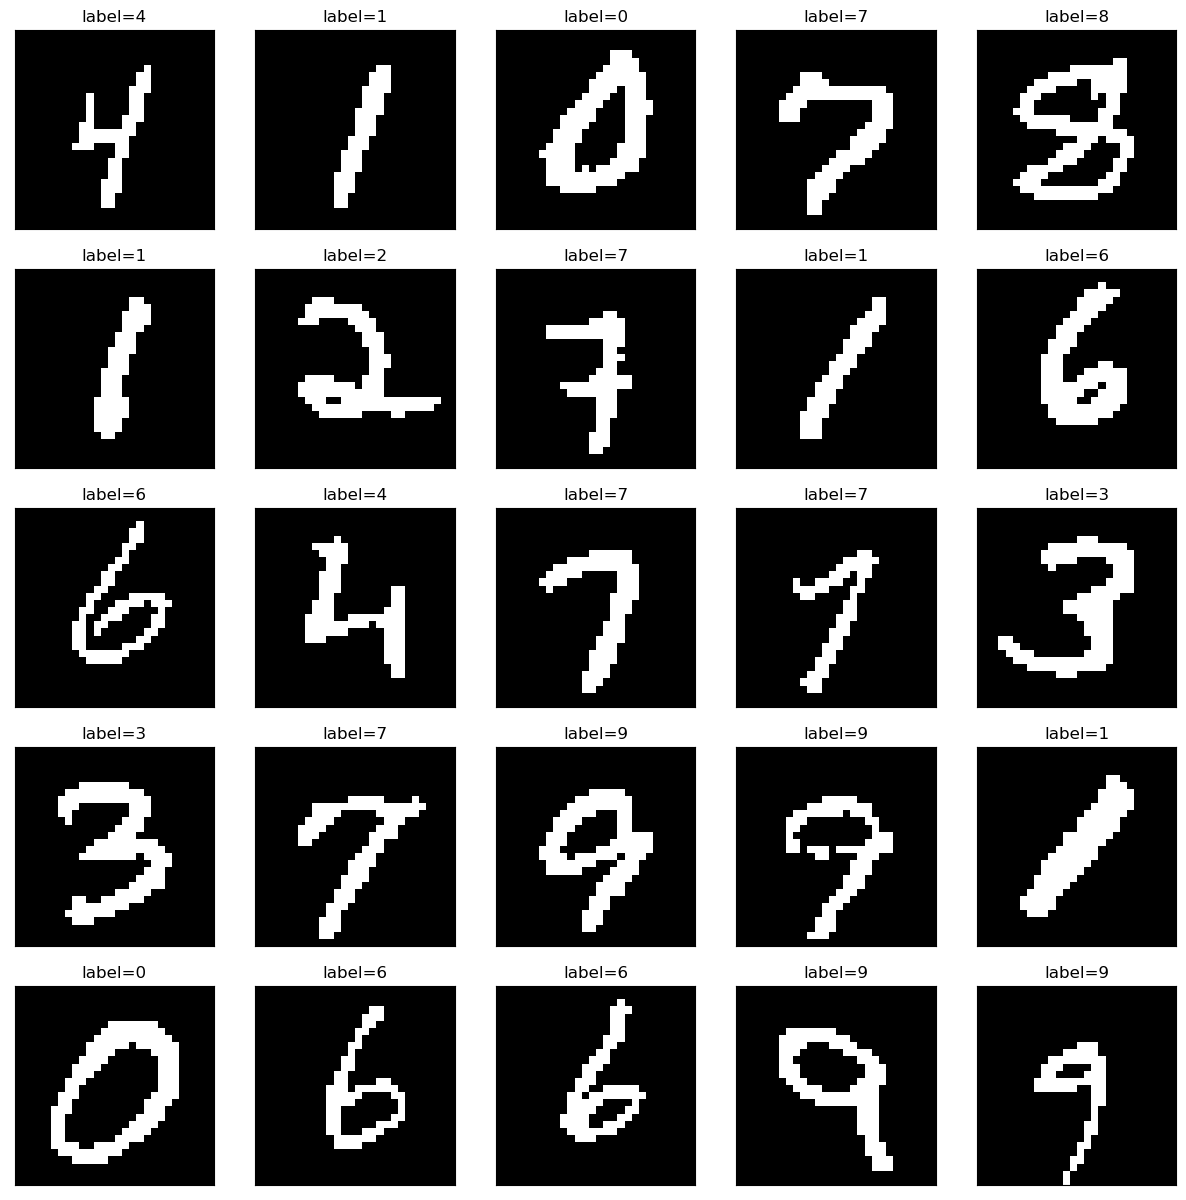

In [3]:
test_mnist.show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

In [4]:
len(train_ds['image'])

60000

In [5]:
train_ds['image'][0].shape

(784,)

In [46]:
config = test_mnist.get_config()

## A boolean logic net

In [110]:
def nln(type, x, width):
    x = hard_or.or_layer(type)(width, nn.initializers.uniform(1.0), dtype=jnp.float32)(x)
    x = hard_not.not_layer(type)(10, dtype=jnp.float32)(x)
    x = primitives.nl_ravel(type)(x)
    x = harden_layer.harden_layer(type)(x)
    x = primitives.nl_reshape(type)((10, width))(x)
    x = primitives.nl_sum(type)(-1)(x)
    return x

In [111]:
def batch_nln(type, x, width):
    return jax.vmap(lambda x: nln(type, x, width))(x)

## A narrow boolean logic net

In [112]:
width = 10
soft, _, _ = neural_logic_net.net(lambda type, x: batch_nln(type, x, width=width))

In [113]:
config.num_epochs = 10
trained_state = test_mnist.train_and_evaluate(soft, (train_ds, test_ds), config=config, workdir="./mnist_metrics")

epoch:  1, train_loss: 2.0432, train_accuracy: 27.02, test_loss: 1.3980, test_accuracy: 55.59
epoch:  2, train_loss: 1.3677, train_accuracy: 55.08, test_loss: 1.3361, test_accuracy: 56.47
epoch:  3, train_loss: 1.3353, train_accuracy: 56.04, test_loss: 1.3301, test_accuracy: 55.79
epoch:  4, train_loss: 1.3256, train_accuracy: 56.30, test_loss: 1.3098, test_accuracy: 55.73
epoch:  5, train_loss: 1.3154, train_accuracy: 56.68, test_loss: 1.3147, test_accuracy: 54.73
epoch:  6, train_loss: 1.3139, train_accuracy: 56.42, test_loss: 1.3242, test_accuracy: 55.65
epoch:  7, train_loss: 1.3116, train_accuracy: 56.53, test_loss: 1.3247, test_accuracy: 54.78
epoch:  8, train_loss: 1.3091, train_accuracy: 56.46, test_loss: 1.2913, test_accuracy: 58.28
epoch:  9, train_loss: 1.3058, train_accuracy: 56.70, test_loss: 1.3576, test_accuracy: 53.34
epoch: 10, train_loss: 1.3021, train_accuracy: 56.85, test_loss: 1.3020, test_accuracy: 55.26


In [114]:
_, hard, symbolic = neural_logic_net.net(lambda type, x: test_mnist.nln(type, x, width))
test_mnist.check_symbolic((soft, hard, symbolic), (train_ds, test_ds), trained_state)

soft_net: final test_loss: 1.3020, final test_accuracy: 55.26


100%|██████████| 10000/10000 [00:50<00:00, 196.85it/s]


hard_net: final test_accuracy: 55.26


In [115]:
symbolic_weights = harden.symbolic_weights(trained_state.params)
symbolic_weights

FrozenDict({
    SymbolicNotLayer_0: {
        weights: DeviceArray([[ True, False, False, False,  True,  True,  True,  True,
                       True, False],
                     [False, False,  True,  True, False,  True, False, False,
                       True,  True],
                     [False, False,  True,  True,  True,  True,  True,  True,
                       True, False],
                     [False, False,  True, False, False,  True,  True,  True,
                       True,  True],
                     [ True,  True, False,  True,  True, False,  True,  True,
                      False, False],
                     [False, False, False, False, False,  True,  True,  True,
                       True,  True],
                     [False,  True,  True,  True,  True,  True,  True, False,
                      False, False],
                     [ True,  True, False, False,  True, False, False,  True,
                      False,  True],
                     [ True, Fal

In [116]:
hard_input = harden.harden(test_ds['image'])
symbolic_input = [f"x{i}" for i in range(len(hard_input[0].tolist()))]
print(" ".join(symbolic_input))

x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19 x20 x21 x22 x23 x24 x25 x26 x27 x28 x29 x30 x31 x32 x33 x34 x35 x36 x37 x38 x39 x40 x41 x42 x43 x44 x45 x46 x47 x48 x49 x50 x51 x52 x53 x54 x55 x56 x57 x58 x59 x60 x61 x62 x63 x64 x65 x66 x67 x68 x69 x70 x71 x72 x73 x74 x75 x76 x77 x78 x79 x80 x81 x82 x83 x84 x85 x86 x87 x88 x89 x90 x91 x92 x93 x94 x95 x96 x97 x98 x99 x100 x101 x102 x103 x104 x105 x106 x107 x108 x109 x110 x111 x112 x113 x114 x115 x116 x117 x118 x119 x120 x121 x122 x123 x124 x125 x126 x127 x128 x129 x130 x131 x132 x133 x134 x135 x136 x137 x138 x139 x140 x141 x142 x143 x144 x145 x146 x147 x148 x149 x150 x151 x152 x153 x154 x155 x156 x157 x158 x159 x160 x161 x162 x163 x164 x165 x166 x167 x168 x169 x170 x171 x172 x173 x174 x175 x176 x177 x178 x179 x180 x181 x182 x183 x184 x185 x186 x187 x188 x189 x190 x191 x192 x193 x194 x195 x196 x197 x198 x199 x200 x201 x202 x203 x204 x205 x206 x207 x208 x209 x210 x211 x212 x213 x214 x215 x216 x217 x218 x219 x220 x221 

In [117]:
symbolic_output = symbolic.apply({'params': symbolic_weights}, symbolic_input)
len(symbolic_output)

10

In [118]:
print(''.join(symbolic_output[0][:symbolic_output[0].index('+') + 1]) + " ...")


((((((((((not(((x0 and True) or (x1 and True) or (x2 and False) or (x3 and False) or (x4 and True) or (x5 and False) or (x6 and False) or (x7 and False) or (x8 and True) or (x9 and True) or (x10 and False) or (x11 and True) or (x12 and False) or (x13 and True) or (x14 and False) or (x15 and False) or (x16 and True) or (x17 and False) or (x18 and False) or (x19 and False) or (x20 and True) or (x21 and True) or (x22 and True) or (x23 and True) or (x24 and True) or (x25 and False) or (x26 and False) or (x27 and True) or (x28 and True) or (x29 and True) or (x30 and False) or (x31 and True) or (x32 and False) or (x33 and True) or (x34 and True) or (x35 and True) or (x36 and False) or (x37 and False) or (x38 and False) or (x39 and False) or (x40 and False) or (x41 and False) or (x42 and False) or (x43 and False) or (x44 and False) or (x45 and False) or (x46 and False) or (x47 and False) or (x48 and False) or (x49 and True) or (x50 and False) or (x51 and True) or (x52 and True) or (x53 and Fa

## A wide boolean logic net

In [122]:
width = 1700
soft, _, _ = neural_logic_net.net(lambda type, x: test_mnist.batch_nln(type, x, width=width))

In [124]:
config.num_epochs = 2
trained_state = test_mnist.train_and_evaluate(soft, (train_ds, test_ds), config=config, workdir="./mnist_metrics")

epoch:  1, train_loss: 66.5427, train_accuracy: 42.61, test_loss: 1.0257, test_accuracy: 81.15
epoch:  2, train_loss: 0.7873, train_accuracy: 83.69, test_loss: 0.8413, test_accuracy: 85.13
